# Explorando os dados de corridas registrado no Strava

In [12]:
import gpxpy
import pandas as pd
import numpy as np
#from geopy.distance import geodesic

In [2]:
# Função para ler o arquivo GPX e converter em um DataFrame do Pandas
def gpx_to_dataframe(gpx_file):
    # Abrir e ler o arquivo GPX
    with open(gpx_file, 'r') as file:
        gpx = gpxpy.parse(file)

    # Lista para armazenar os dados de cada ponto
    data = []

    # Iterar sobre os pontos do track (trilha)
    for track in gpx.tracks:
        for segment in track.segments:
            for point in segment.points:
                # Adicionar os dados do ponto à lista
                data.append({
                    'latitude': point.latitude,
                    'longitude': point.longitude,
                    'elevation': point.elevation,
                    'time': point.time
                })

    # Converter a lista em um DataFrame do Pandas
    df = pd.DataFrame(data)
    return df

In [3]:
# Exemplo de uso
gpx_file = 'tricolor_run.gpx'
df = gpx_to_dataframe(gpx_file)

In [4]:
df

,latitude,longitude,elevation,time
0,-23.598371,-46.720313,744.3,2024-07-20 23:00:45+00:00
1,-23.598335,-46.720307,744.2,2024-07-20 23:00:46+00:00
2,-23.598318,-46.720305,744.2,2024-07-20 23:00:47+00:00
3,-23.598302,-46.720303,744.2,2024-07-20 23:00:48+00:00
4,-23.598267,-46.720289,744.1,2024-07-20 23:00:49+00:00
...,...,...,...,...
3748,-23.600664,-46.719579,749.7,2024-07-21 00:03:13+00:00
3749,-23.600675,-46.719581,749.7,2024-07-21 00:03:14+00:00
3750,-23.600675,-46.719592,749.7,2024-07-21 00:03:15+00:00
3751,-23.600680,-46.719593,749.7,2024-07-21 00:03:16+00:00


Distância Percorrida

In [16]:
import numpy as np
from geopy.distance import geodesic

def calculate_total_distance(df):
    # Calcular a distância entre cada ponto
    distances = []
    for i in range(1, len(df)):
        coords_1 = (df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude'])
        coords_2 = (df.iloc[i]['latitude'], df.iloc[i]['longitude'])
        distances.append(geodesic(coords_1, coords_2).meters)  # Distância em metros
    
    # Somar as distâncias
    total_distance = np.sum(distances)
    return total_distance

# Exemplo de uso
total_distance = calculate_total_distance(df)
print(f"Distância total percorrida: {total_distance:.2f} metros")

Distância total percorrida: 10399.38 metros


Ganho e Perda de Elevação

In [13]:
def calculate_elevation_gain_loss(df):
    elevation_gain = 0
    elevation_loss = 0
    
    for i in range(1, len(df)):
        delta_elevation = df.iloc[i]['elevation'] - df.iloc[i-1]['elevation']
        if delta_elevation > 0:
            elevation_gain += delta_elevation
        else:
            elevation_loss += abs(delta_elevation)
    
    return elevation_gain, elevation_loss

# Exemplo de uso
elevation_gain, elevation_loss = calculate_elevation_gain_loss(df)
print(f"Ganho de elevação: {elevation_gain:.2f} metros")
print(f"Perda de elevação: {elevation_loss:.2f} metros")


Ganho de elevação: 176.40 metros
Perda de elevação: 170.40 metros


Velocidade Média

In [17]:
def calculate_average_speed(df):
    # Distância total
    total_distance = calculate_total_distance(df)  # em metros
    
    # Tempo total (em segundos)
    time_start = pd.to_datetime(df['time'].iloc[0])
    time_end = pd.to_datetime(df['time'].iloc[-1])
    total_time = (time_end - time_start).total_seconds()
    
    # Velocidade média (m/s)
    avg_speed = total_distance / total_time
    return avg_speed * 3.6  # Convertendo para km/h

# Exemplo de uso
average_speed = calculate_average_speed(df)
print(f"Velocidade média: {average_speed:.2f} km/h")


Velocidade média: 9.98 km/h


Pace

In [18]:
def calculate_pace(df):
    total_distance = calculate_total_distance(df)  # Distância em metros
    total_time = (pd.to_datetime(df['time'].iloc[-1]) - pd.to_datetime(df['time'].iloc[0])).total_seconds()
    
    # Convertendo distância para km e tempo para minutos
    pace_per_km = (total_time / 60) / (total_distance / 1000)
    return pace_per_km

# Exemplo de uso
pace = calculate_pace(df)
print(f"Ritmo médio: {pace:.2f} min/km")


Ritmo médio: 6.01 min/km


Elevação

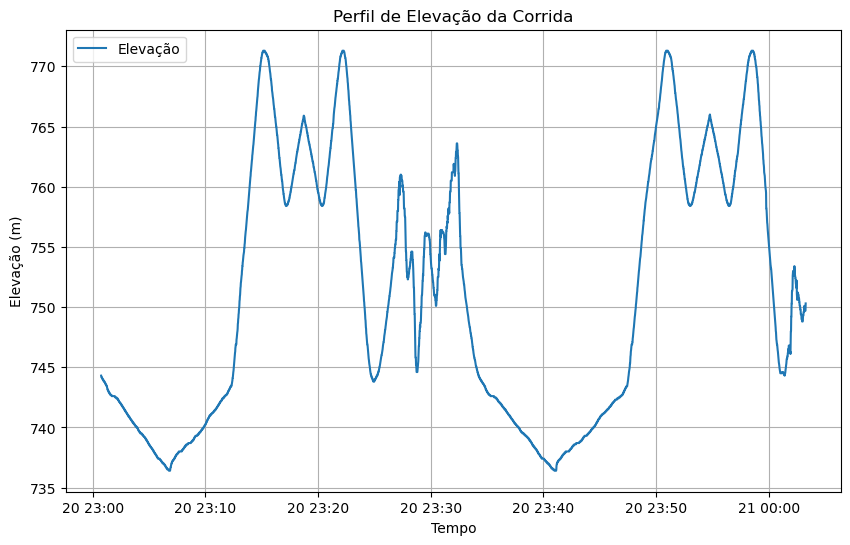

In [20]:
import matplotlib.pyplot as plt
import pandas as pd

# Função para remover timezone da coluna 'time'
def remove_timezone(df):
    df['time'] = pd.to_datetime(df['time']).dt.tz_convert(None)
    return df

# Função para plotar o perfil de elevação
def plot_elevation(df):
    # Remover o timezone da coluna 'time'
    df = remove_timezone(df)
    
    plt.figure(figsize=(10, 6))
    plt.plot(df['time'], df['elevation'], label='Elevação')
    plt.xlabel('Tempo')
    plt.ylabel('Elevação (m)')
    plt.title('Perfil de Elevação da Corrida')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemplo de uso
plot_elevation(df)


Velocidade ao Longo da corrida

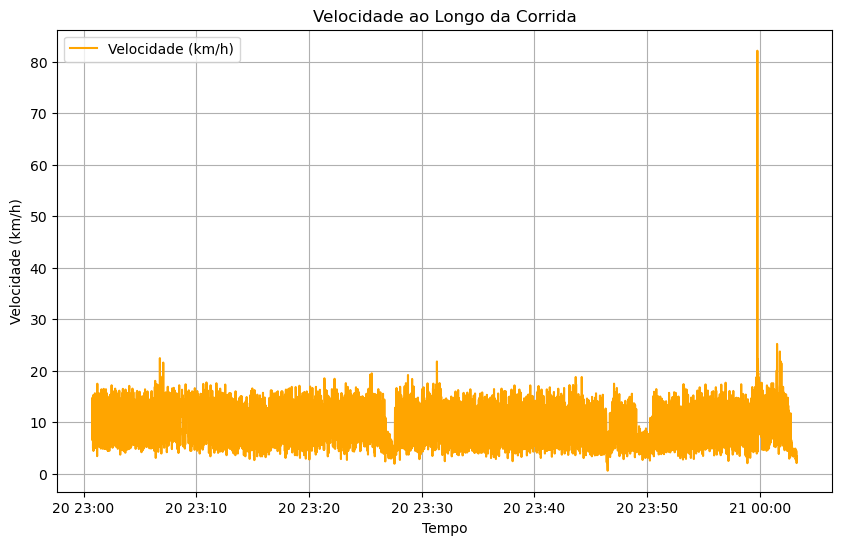

In [21]:
def calculate_instantaneous_speed(df):
    speeds = []
    for i in range(1, len(df)):
        coords_1 = (df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude'])
        coords_2 = (df.iloc[i]['latitude'], df.iloc[i]['longitude'])
        distance = geodesic(coords_1, coords_2).meters
        
        # Calcular tempo entre os pontos
        time_1 = pd.to_datetime(df.iloc[i-1]['time'])
        time_2 = pd.to_datetime(df.iloc[i]['time'])
        time_delta = (time_2 - time_1).total_seconds()
        
        # Calcular velocidade (m/s) e converter para km/h
        if time_delta > 0:
            speed = (distance / time_delta) * 3.6  # Convertendo para km/h
            speeds.append(speed)
    
    return speeds

def plot_speed(df):
    speeds = calculate_instantaneous_speed(df)
    times = df['time'][1:]  # Ajustar o tempo para o número de velocidades
    
    plt.figure(figsize=(10, 6))
    plt.plot(times, speeds, label='Velocidade (km/h)', color='orange')
    plt.xlabel('Tempo')
    plt.ylabel('Velocidade (km/h)')
    plt.title('Velocidade ao Longo da Corrida')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemplo de uso
plot_speed(df)


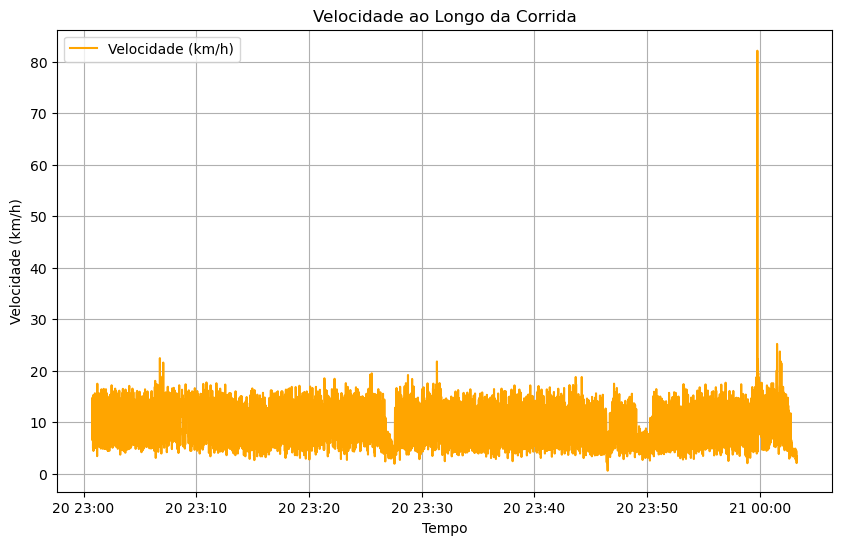

In [22]:
def calculate_instantaneous_speed(df):
    speeds = []
    for i in range(1, len(df)):
        coords_1 = (df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude'])
        coords_2 = (df.iloc[i]['latitude'], df.iloc[i]['longitude'])
        distance = geodesic(coords_1, coords_2).meters
        
        # Calcular tempo entre os pontos
        time_1 = pd.to_datetime(df.iloc[i-1]['time'])
        time_2 = pd.to_datetime(df.iloc[i]['time'])
        time_delta = (time_2 - time_1).total_seconds()
        
        # Calcular velocidade (m/s) e converter para km/h
        if time_delta > 0:
            speed = (distance / time_delta) * 3.6  # Convertendo para km/h
            speeds.append(speed)
    
    return speeds

def plot_speed(df):
    speeds = calculate_instantaneous_speed(df)
    times = df['time'][1:]  # Ajustar o tempo para o número de velocidades
    
    plt.figure(figsize=(10, 6))
    plt.plot(times, speeds, label='Velocidade (km/h)', color='orange')
    plt.xlabel('Tempo')
    plt.ylabel('Velocidade (km/h)')
    plt.title('Velocidade ao Longo da Corrida')
    plt.legend()
    plt.grid(True)
    plt.show()

# Exemplo de uso
plot_speed(df)


In [23]:
import folium
import pandas as pd

# Função para plotar o percurso no mapa
def plot_course_on_map(df):
    # Inicializar o mapa centrado no ponto inicial do percurso
    start_location = [df['latitude'].iloc[0], df['longitude'].iloc[0]]
    m = folium.Map(location=start_location, zoom_start=15)
    
    # Adicionar o percurso ao mapa (linha conectando as coordenadas)
    coordinates = list(zip(df['latitude'], df['longitude']))
    folium.PolyLine(coordinates, color='blue', weight=5, opacity=0.8).add_to(m)
    
    # Marcar o ponto de início e fim da corrida
    folium.Marker(location=start_location, popup="Início", icon=folium.Icon(color="green")).add_to(m)
    end_location = [df['latitude'].iloc[-1], df['longitude'].iloc[-1]]
    folium.Marker(location=end_location, popup="Fim", icon=folium.Icon(color="red")).add_to(m)
    
    # Mostrar o mapa
    return m

# Exemplo de uso
mapa = plot_course_on_map(df)
mapa

In [27]:
import folium
import pandas as pd
import numpy as np
from folium.plugins import AntPath

# Função Haversine para calcular a distância entre dois pontos (em metros)
def haversine(lat1, lon1, lat2, lon2):
    R = 6371000  # Raio da Terra em metros
    phi1 = np.radians(lat1)
    phi2 = np.radians(lat2)
    delta_phi = np.radians(lat2 - lat1)
    delta_lambda = np.radians(lon2 - lon1)
    
    a = np.sin(delta_phi / 2) ** 2 + np.cos(phi1) * np.cos(phi2) * np.sin(delta_lambda / 2) ** 2
    c = 2 * np.arctan2(np.sqrt(a), np.sqrt(1 - a))
    
    return R * c  # Retorna a distância em metros

# Função para calcular o pace (minutos por km) entre os pontos do percurso
def calculate_pace(df):
    paces = [np.nan]  # Inicializando com NaN para o primeiro ponto
    
    for i in range(1, len(df)):
        lat1, lon1 = df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude']
        lat2, lon2 = df.iloc[i]['latitude'], df.iloc[i]['longitude']
        distance = haversine(lat1, lon1, lat2, lon2) / 1000  # Distância em km
        
        # Tempo entre os dois pontos (em minutos)
        time_diff = (df.iloc[i]['time'] - df.iloc[i-1]['time']).total_seconds() / 60
        
        # Calcular o pace (min/km)
        if distance > 0:
            pace = time_diff / distance
            paces.append(pace)
        else:
            paces.append(np.nan)  # Evitar divisão por zero
    
    return paces

# Função para criar um mapa com o percurso e o pace
def plot_pace_on_map(df):
    # Calcular pace
    df['pace'] = calculate_pace(df)
    
    # Inicializar o mapa centralizado na primeira coordenada
    start_coords = (df['latitude'].iloc[0], df['longitude'].iloc[0])
    folium_map = folium.Map(location=start_coords, zoom_start=15)

    # Função para definir a cor com base no pace
    def get_color(pace):
        if np.isnan(pace):
            return 'gray'
        elif pace < 5:
            return 'green'  # Pace rápido
        elif 5 <= pace < 7:
            return 'yellow'  # Pace moderado
        else:
            return 'red'  # Pace mais lento
    
    # Adicionar o percurso ao mapa
    for i in range(1, len(df)):
        point1 = (df.iloc[i-1]['latitude'], df.iloc[i-1]['longitude'])
        point2 = (df.iloc[i]['latitude'], df.iloc[i]['longitude'])
        pace = df.iloc[i]['pace']
        
        # Adicionar linha com cor correspondente ao pace
        folium.PolyLine([point1, point2], color=get_color(pace), weight=5).add_to(folium_map)
    
    # Exibir o mapa
    return folium_map

# Exemplo de uso
df['time'] = pd.to_datetime(df['time'])  # Garantir que a coluna 'time' seja datetime

# Plotar o pace no mapa
folium_map = plot_pace_on_map(df)

# Salvar o mapa em um arquivo HTML ou exibir diretamente
folium_map.save("pace_map.html")
folium_map
